<a href="https://colab.research.google.com/github/swet-s/HC_Reg/blob/main/HC_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Downloading images and pixel size sheet

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
# download link: https://drive.google.com/file/d/1nx8oTD1mdhB9e19xAZQYsdgOPt-4QUvl/view?usp=sharing
file_id_1 = '1nx8oTD1mdhB9e19xAZQYsdgOPt-4QUvl'  
downloaded_1 = drive.CreateFile({'id': file_id_1}) 

# download link: https://drive.google.com/file/d/1OSrIuKWasvLss0Ewbx5EyTEPKSQ1nM6k/view?usp=sharing
file_id_2 = '1OSrIuKWasvLss0Ewbx5EyTEPKSQ1nM6k'  
downloaded_2 = drive.CreateFile({'id': file_id_2})

# download link: https://drive.google.com/file/d/1dNPGG7FeI3vOC6lFsRhLdt4IrpIj1enH/view?usp=sharing
file_id_3 = '1dNPGG7FeI3vOC6lFsRhLdt4IrpIj1enH' 
downloaded_3 = drive.CreateFile({'id': file_id_3})

In [ ]:
!rm -r train.zip
!rm -r test.zip
!rm -r test_set_pixel_size.csv

rm: cannot remove 'train.zip': No such file or directory
rm: cannot remove 'test.zip': No such file or directory
rm: cannot remove 'test_set_pixel_size.csv': No such file or directory


In [ ]:
downloaded_1.GetContentFile('train.zip')
downloaded_2.GetContentFile('test.zip')
downloaded_3.GetContentFile('test_set_pixel_size.csv')

!unzip train.zip
!unzip test.zip

Archive:  train.zip
replace train/002_HC_Mask.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  test.zip
replace test/000_HC.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Downloading trained model

In [ ]:
!rm -r mlruns

In [ ]:
# download link: https://drive.google.com/file/d/1-JCnON0FHDQO1hym_9PH4DijLSFL9jCY/view?usp=sharing 
file_id_mlruns = '1-JCnON0FHDQO1hym_9PH4DijLSFL9jCY'  
downloaded_mlruns = drive.CreateFile({'id': file_id_mlruns})

downloaded_mlruns.GetContentFile('mlruns.zip')

!unzip mlruns.zip

#Importing libraries and setting up GPU

In [ ]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook 
import copy
import glob

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import mlflow
import mlflow.pytorch

import cv2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#Mask generation for annotated images

In [ ]:
def mask_generator(source_file_path, dest_file_path):
    file_names = sorted([file for _,_,files in os.walk(source_file_path) for file in files])
    for i, file_name in enumerate(file_names):
        if i % 2 != 0:
            im = cv2.imread(source_file_path+file_name)
            imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            ret,thresh = cv2.threshold(imgray,127,255,0)
            im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            ellipse = cv2.fitEllipse(contours[0])
            im1 = cv2.ellipse(im,ellipse,(255,255,255),-1)
            image_name = file_name.replace('Annotation', 'Mask')
            cv2.imwrite(dest_file_path+image_name, im1)
    
    return 1

#Dataloader

In [ ]:
#For converting the dataset to torchvision dataset format
class HC18Dataset(Dataset):
    def __init__(self, file_path,train=True):        
        self.file_path = file_path
        self.train = train
        if self.train:
            self.transform_x = transforms.Compose([
                transforms.Resize((432, 640)), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.transform_y = transforms.Compose([
                    transforms.Resize((432, 640)), 
                    transforms.ToTensor()
            ])
            self.X_train_file_names = []
            self.Y_train_file_names = []
            file_names = sorted([file for _,_,files in os.walk(self.file_path) for file in files])
            for i, file_name in enumerate(file_names):
                if i % 2 == 0:
                    self.X_train_file_names.append(file_name)
                else:
                    self.Y_train_file_names.append(file_name)
            self.len = len(self.X_train_file_names)
            
        else:
            self.transform_x = transforms.Compose([
                transforms.Resize((432, 640)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.X_test_file_names = sorted([file for _,_,files in os.walk(self.file_path) for file in files])
            self.len = len(self.X_test_file_names)
            
            
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):        
        if self.train:
            X_train_file_name = self.X_train_file_names[index]
            Y_train_file_name = self.Y_train_file_names[index]
            x_train = self.pil_loader(self.file_path+"/"+X_train_file_name)
            y_train = self.pil_loader(self.file_path+"/"+Y_train_file_name)
            return self.transform_x(x_train), self.transform_y(y_train), X_train_file_name, Y_train_file_name
        else:
            file_name = self.X_test_file_names[index]
            x_test = self.pil_loader(self.file_path+"/"+file_name)
            return self.transform_x(x_test), file_name
                
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')


In [ ]:
full_data = HC18Dataset("train",train=True)

#Spliting Training and Validation Set 80:20

In [ ]:
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

In [ ]:
batch_size = 2


# Load Training Data

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)


# Load Test Data

In [ ]:
test_data = HC18Dataset("test",train=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)


# Show Images


In [ ]:
def imshow(img, title):
    npimg = img.numpy() *0.5 + 0.5   # un-normalizing the image
    plt.figure(figsize=(batch_size*5, 5))
    #plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
def show_train_batch_images(dataloader):
    x, y, xf, yf = next(iter(dataloader))
    x = torchvision.utils.make_grid(x)
    y = torchvision.utils.make_grid(y)
    imshow(x, title=[n for n in xf])
    imshow(y, title=[n for n in yf])

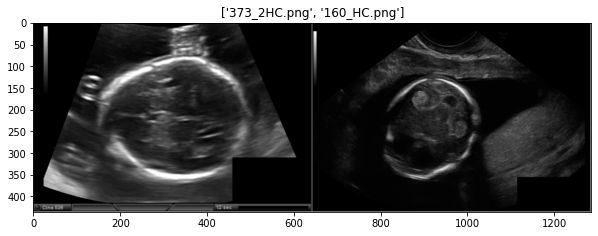

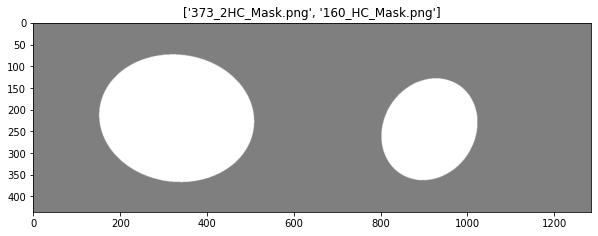

In [ ]:
show_train_batch_images(validation_loader)

#Models

In [ ]:
class UNet(nn.Module):
    def __init__(self): 
        super(UNet, self).__init__()
        self.down_sample_conv_1 = self.down_sample_conv(1)
        self.down_sample_conv_2 = self.down_sample_conv(64)
        self.down_sample_conv_3 = self.down_sample_conv(128)
        self.down_sample_conv_4 = self.down_sample_conv(256)
        self.down_sample_conv_5 = self.down_sample_conv(512)
        
        self.upconv_4 = self.up_conv(1024)
        self.up_sample_conv_4 = self.up_sample_conv(1024)
        self.upconv_3 = self.up_conv(512)
        self.up_sample_conv_3 = self.up_sample_conv(512)
        self.upconv_2 = self.up_conv(256)
        self.up_sample_conv_2 = self.up_sample_conv(256)
        self.upconv_1 = self.up_conv(128)
        self.up_sample_conv_1 = self.up_sample_conv(128)
        
        self.final_conv = nn.Conv2d(64, 2, kernel_size=1, stride=1, padding=0)
    
    def down_sample_conv(self, in_feature_maps):
        return nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
            
        ) if in_feature_maps == 1 else nn.Sequential(
            nn.Conv2d(in_feature_maps, 2*in_feature_maps, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(2*in_feature_maps, 2*in_feature_maps, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
            
        )
      
    def down_sample(self):
        return nn.MaxPool2d(kernel_size=2, stride=2)
      
    def up_sample_conv(self, in_feature_maps):
        return nn.Sequential(
            nn.Conv2d(in_feature_maps, int(0.5*in_feature_maps), kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(int(0.5*in_feature_maps), int(0.5*in_feature_maps), kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
            
        )
      
    def up_conv(self, in_feature_maps):
        return nn.ConvTranspose2d(in_feature_maps, int(0.5*in_feature_maps), kernel_size=2, stride=2, padding=0)
      
    def crop_concat(self, x1, x2):
        in_width = x1.shape[-1]
        out_width = x2.shape[-1]
        crop_width = (in_width - out_width) // 2
        
        in_height = x1.shape[-2]
        out_height = x2.shape[-2]
        crop_height = (in_height - out_height) // 2
        
        x1 = x1[:, :, crop_height:(in_height-crop_height), crop_width:(in_width-crop_width)]
        return torch.cat((x1, x2), 1)
        
    def forward(self, x):
        #Downsampling or contraction
        x1 = self.down_sample_conv_1(x)
        #print(x1.shape)
        x2 = self.down_sample_conv_2(self.down_sample()(x1))
        #print(x2.shape)
        x3 = self.down_sample_conv_3(self.down_sample()(x2))
        #print(x3.shape)
        x4 = self.down_sample_conv_4(self.down_sample()(x3))
        #print(x4.shape)
        x5 = self.down_sample_conv_5(self.down_sample()(x4))
        #print(x5.shape)
        #print('--------------------------------------------------\n')
        
        #Upsampling or expansion
        x4_u = self.upconv_4(x5)
        x4_u = self.up_sample_conv_4(self.crop_concat(x4, x4_u))
        #print(x4_u.shape)
        x3_u = self.upconv_3(x4_u)
        x3_u = self.up_sample_conv_3(self.crop_concat(x3, x3_u))
        #print(x3_u.shape)
        x2_u = self.upconv_2(x3_u)
        x2_u = self.up_sample_conv_2(self.crop_concat(x2, x2_u))
        #print(x2_u.shape)
        x1_u = self.upconv_1(x2_u)
        x1_u = self.up_sample_conv_1(self.crop_concat(x1, x1_u))
        #print(x1_u.shape)
        y = self.final_conv(x1_u)
        #print(y.shape)           
        return y

In [ ]:
class Channel_Attention(nn.Module):
    '''Channel Attention in CBAM.
    '''

    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        '''Param init and architecture building.
        '''

        super(Channel_Attention, self).__init__()
        self.pool_types = pool_types

        self.shared_mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=channel_in, out_features=channel_in//reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=channel_in//reduction_ratio, out_features=channel_in)
        )


    def forward(self, x):
        '''Forward Propagation.
        '''

        channel_attentions = []

        for pool_types in self.pool_types:
            if pool_types == 'avg':
                pool_init = nn.AvgPool2d(kernel_size=(x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                avg_pool = pool_init(x)
                channel_attentions.append(self.shared_mlp(avg_pool))
            elif pool_types == 'max':
                pool_init = nn.MaxPool2d(kernel_size=(x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                max_pool = pool_init(x)
                channel_attentions.append(self.shared_mlp(max_pool))

        pooling_sums = torch.stack(channel_attentions, dim=0).sum(dim=0)
        scaled = nn.Sigmoid()(pooling_sums).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * scaled #return the element-wise multiplication between the input and the result.


class ChannelPool(nn.Module):
    '''Merge all the channels in a feature map into two separate channels where the first channel is produced by taking the max values from all channels, while the
       second one is produced by taking the mean from every channel.
    '''
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)


class Spatial_Attention(nn.Module):
    '''Spatial Attention in CBAM.
    '''

    def __init__(self, kernel_size=7):
        '''Spatial Attention Architecture.
        '''

        super(Spatial_Attention, self).__init__()

        self.compress = ChannelPool()
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=kernel_size, stride=1, dilation=1, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(num_features=1, eps=1e-5, momentum=0.01, affine=True)
        )


    def forward(self, x):
        '''Forward Propagation.
        '''
        x_compress = self.compress(x)
        x_output = self.spatial_attention(x_compress)
        scaled = nn.Sigmoid()(x_output)
        return x * scaled


class CBAM(nn.Module):
    '''CBAM architecture.
    '''
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        '''Param init and arch build.
        '''
        super(CBAM, self).__init__()
        self.spatial = spatial

        self.channel_attention = Channel_Attention(channel_in=channel_in, reduction_ratio=reduction_ratio, pool_types=pool_types)

        if self.spatial:
            self.spatial_attention = Spatial_Attention(kernel_size=7)


    def forward(self, x):
        '''Forward Propagation.
        '''
        x_out = self.channel_attention(x)
        if self.spatial:
            x_out = self.spatial_attention(x_out)

        return x_out

class BottleNeck(nn.Module):
    '''Bottleneck modules
    '''

    def __init__(self, in_channels, out_channels, expansion=4, stride=1, use_cbam=True):
        '''Param init.
        '''
        super(BottleNeck, self).__init__()

        self.use_cbam = use_cbam
        #only the first conv will be affected by the given stride parameter. The rest have default stride value (which is 1).
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, bias=False, stride=stride)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels*expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=out_channels*expansion)
        self.relu = nn.ReLU(inplace=True)

        #since the input has to be same size with the output during the identity mapping, whenever the stride or the number of output channels are
        #more than 1 and expansion*out_channels respectively, the input, x, has to be downsampled to the same level as well.
        self.identity_connection = nn.Sequential()
        if stride != 1 or in_channels != expansion*out_channels:
            self.identity_connection = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=expansion*out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_features=out_channels*expansion)
            )

        if self.use_cbam:
            self.cbam = CBAM(channel_in=out_channels*expansion)


    def forward(self, x):
        '''Forward Propagation.
        '''

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.use_cbam:
            out = self.cbam(out)

        out += self.identity_connection(x) #identity connection/skip connection
        out = self.relu(out)

        return out


class ResNet50(nn.Module):
    '''ResNet-50 Architecture.
    '''

    def __init__(self, use_cbam=True, image_depth=3, num_classes=6):
        '''Params init and build arch.
        '''
        super(ResNet50, self).__init__()

        self.in_channels = 64
        self.expansion = 4
        self.num_blocks = [3, 3, 3, 2]

        self.conv_block1 = nn.Sequential(nn.Conv2d(kernel_size=7, stride=2, in_channels=image_depth, out_channels=self.in_channels, padding=3, bias=False),
                                            nn.BatchNorm2d(self.in_channels),
                                            nn.ReLU(inplace=True),
                                            nn.MaxPool2d(stride=2, kernel_size=3, padding=1))

        self.layer1 = self.make_layer(out_channels=64, num_blocks=self.num_blocks[0], stride=1, use_cbam=use_cbam)
        self.layer2 = self.make_layer(out_channels=128, num_blocks=self.num_blocks[1], stride=2, use_cbam=use_cbam)
        self.layer3 = self.make_layer(out_channels=256, num_blocks=self.num_blocks[2], stride=2, use_cbam=use_cbam)
        self.layer4 = self.make_layer(out_channels=512, num_blocks=self.num_blocks[3], stride=2, use_cbam=use_cbam)
        self.avgpool = nn.AvgPool2d(7)
        self.linear = nn.Linear(512*self.expansion, num_classes)


    def make_layer(self, out_channels, num_blocks, stride, use_cbam):
        '''To construct the bottleneck layers.
        '''
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BottleNeck(in_channels=self.in_channels, out_channels=out_channels, stride=stride, expansion=self.expansion, use_cbam=use_cbam))
            self.in_channels = out_channels * self.expansion
        return nn.Sequential(*layers)


    def forward(self, x):
        '''Forward propagation of ResNet-50.
        '''

        x = self.conv_block1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x_conv = self.layer4(x)
        x = self.avgpool(x_conv)
        x = nn.Flatten()(x) #flatten the feature maps.
        x = self.linear(x)

        return x_conv, x

#Training and Validation

In [ ]:
def train(epoch):
    
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, targets, _, _ = data               
        
        tragets = torch.ceil(targets)     
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets = targets.view(targets.shape[0], targets.shape[2], targets.shape[3]).long()
                
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        opt.step()
        
        if batch_id % args.log_interval == 0:
            #pos = epoch * len(train_loader) + batch_id
            #mlflow.log_metric('train_loss', loss.data.item())            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))
        
        del inputs, targets, outputs, loss
        torch.cuda.empty_cache()

In [ ]:
def validate(epoch):
    
    model.eval()
    validation_loss = 0
    
    with torch.no_grad():
        
        for inputs, targets, _, _ in validation_loader:
          
            tragets = torch.ceil(targets)
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = targets.view(targets.shape[0], targets.shape[2], targets.shape[3]).long()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            validation_loss += loss.data.item()        
            
            del inputs, targets, outputs
            torch.cuda.empty_cache()
            
        validation_loss /= len(validation_loader.dataset)
        
        #pos = (epoch + 1) * len(train_loader)
        #mlflow.log_metric('validation_loss', validation_loss)
        
        print('\nEpoch: {}, Validation set: Average loss: {:.4f}\n'.
              format(epoch, validation_loss))  
        
        return validation_loss


In [ ]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(batch_size, 10, 0, 15)

In [ ]:
best_model = None

In [ ]:
# !rm -r mlruns

#Training Starts

In [ ]:
expt_name = 'HC18_CrossEntropy_B1'
# expt_id = mlflow.create_experiment(expt_name)

mlflow.set_experiment(expt_name)

lr = 0.015
momentum = 0.9

expt_id = '%d_%d' % (int(lr*1000), int(momentum*1000))

print('\nLR = %.3f, Momentum = %.3f\n' % (lr, momentum))

if best_model:
    model.load_state_dict(best_model)
else:
    min_validation_loss = np.inf
    torch.manual_seed(args.seed)
    model = UNet()
    model.to(device)

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum, nesterov=True)

with mlflow.start_run(nested=True) as run:                
    for key, value in vars(args).items():
        mlflow.log_param(key, value)
    mlflow.log_param('lr', lr)
    mlflow.log_param('momentum', momentum)

    for epoch in tqdm_notebook(range(1, args.epochs + 1), total=args.epochs, unit="epoch"):
        train(epoch)
        validation_loss = validate(epoch)

        if validation_loss < min_validation_loss:
            min_validation_loss = validation_loss
            best_model = copy.deepcopy(model.state_dict())            

        print("Minimun validation loss so far: {:.3f}\n\n".format(min_validation_loss))   
        
    model.load_state_dict(best_model)
    mlflow.pytorch.log_model(model, "models")
    

In [ ]:
!tar -czvf /content/mlruns.tar.gz /content/mlruns/596802815950690740/9e20ba662f3649338c501d795e316da3

In [ ]:
!zip -r 'mlruns.zip' '/content/mlruns'

In [ ]:
mlflow.pytorch.get_default_pip_requirements()


2022/12/11 17:44:15 WARNING mlflow.utils.requirements_utils: Found torch version (1.13.0+cu116) contains a local version label (+cu116). MLflow logged a pip requirement for this package as 'torch==1.13.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


['torch==1.13.0', 'cloudpickle==1.5.0']

In [ ]:
torch.cuda.is_available()

False

In [ ]:
if torch.cuda.is_available():
    model = mlflow.pytorch.load_model('mlruns/596802815950690740/9e20ba662f3649338c501d795e316da3/artifacts/models')
else:
    model = mlflow.pytorch.load_model('mlruns/596802815950690740/9e20ba662f3649338c501d795e316da3/artifacts/models',  map_location=torch.device('cpu'))


In [ ]:
best_model = copy.deepcopy(model.state_dict())

In [ ]:
print(best_model)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
min_validation_loss = validate(1)


Epoch: 1, Validation set: Average loss: 0.2731



#Dice coefficient

In [ ]:
def dice_coeff(predicts, targets):
    #predicts and targets are of the size: batch x channel x height x width
    
    smooth = 1
    num = targets.size(0)
    m1 = predicts.view(num, -1)
    m2 = targets.view(num, -1)
    intersection = (m1 * m2)

    score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
    score = score.sum() / num
    return score.item()

In [ ]:
def avg_dice_coeff(dataloader):
  
    model.to(device)
    model.eval()
    
    diceCoeff = 0
    
    with torch.no_grad():
    
        for inputs, targets, _, _ in dataloader:
        
            tragets = torch.ceil(targets)
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            outputs = outputs.argmax(1).float()
            
            height, width = outputs.shape[1:]
            
            for output, target in zip(outputs, targets):
                diceCoeff += dice_coeff(output.view(1, 1, height, width), 
                                        target.view(1, 1, height, width))
                
            del inputs, tragets, outputs
            torch.cuda.empty_cache()
            
    diceCoeff /= len(dataloader.dataset)
    return diceCoeff

In [ ]:
avg_dice_coeff(train_loader)

0.07919018755033602

In [ ]:
avg_dice_coeff(validation_loader)

0.08220119120018353